# EYE FOR BLIND

In [1]:
# ! pip install tqdm

In [2]:
#Import all the required libraries
import glob
import os
import shutil
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter,defaultdict
from wordcloud import WordCloud
from nltk.corpus import stopwords
from tqdm import tqdm
import random
import time
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu

In [3]:
import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization,StringLookup
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3
# from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,Model 

### Importing Dataset

In [4]:
dataset_path = '.\\dataset'

if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)
    
if not os.path.isdir(dataset_path):
    os.mkdir(dataset_path)
    
with zipfile.ZipFile('.\\archive.zip','r') as ref:
    ref.extractall(dataset_path)

In [5]:
# reading images into a seperate variable
image_directory_path = str(dataset_path+'\\Images')

uniq_img_path_list = glob.glob(image_directory_path + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(uniq_img_path_list)))

The total images present in the dataset: 8091


In [6]:
uniq_img_path_list[:5]

['.\\dataset\\Images\\1000268201_693b08cb0e.jpg',
 '.\\dataset\\Images\\1001773457_577c3a7d70.jpg',
 '.\\dataset\\Images\\1002674143_1b742ab4b8.jpg',
 '.\\dataset\\Images\\1003163366_44323f5815.jpg',
 '.\\dataset\\Images\\1007129816_e794419615.jpg']

In [7]:
# reading caption dataset
doc = pd.read_csv(str(dataset_path+'/captions.txt'))

with pd.option_context('display.max_colwidth', None):
  display(doc.head(15))

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [8]:
doc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


#### Data visualization 

A child in a pink dress is climbing up a set of stairs in an entry way . A girl going into a wooden building . A little girl climbing into a wooden playhouse . A little girl climbing the stairs to her playhouse . A little girl in a pink dress going into a wooden cabin .


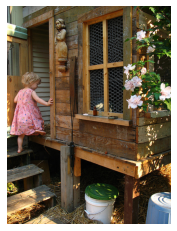

A black dog and a spotted dog are fighting A black dog and a tri-colored dog playing with each other on the road . A black dog and a white dog with brown spots are staring at each other in the street . Two dogs of different breeds looking at each other on the road . Two dogs on pavement moving toward each other .


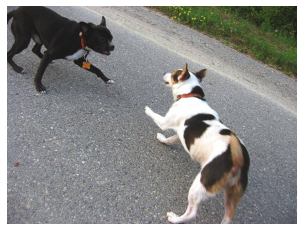

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl . A little girl is sitting in front of a large painted rainbow . A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . There is a girl with pigtails sitting in front of a rainbow painting . Young girl with pigtails painting outside in the grass .


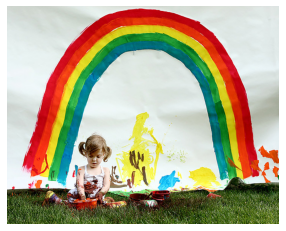

A man lays on a bench while his dog sits by him . A man lays on the bench to which a white dog is also tied . a man sleeping on a bench outside with a white and black dog sitting next to him . A shirtless man lies on a park bench with his dog . man laying on bench holding leash of dog sitting on ground


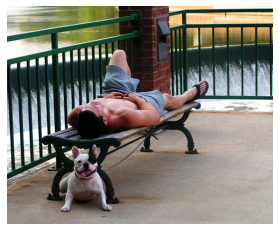

A man in an orange hat starring at something . A man wears an orange hat and glasses . A man with gauges and glasses is wearing a Blitz hat . A man with glasses is wearing a beer can crocheted hat . The man with pierced ears is wearing glasses and an orange hat .


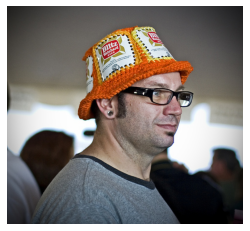

In [9]:
caption_set = doc.groupby('image')['caption'].transform(lambda x: ' '.join(x))
caption_set.drop_duplicates(inplace = True)

#Visualise both the images & text present in the dataset
for i in range(5):
    print(caption_set[5*i])
    image = plt.imread(uniq_img_path_list[i])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Creating a dataframe which summarizes the image, caption & path as a dataframe
Each image id has 5 captions associated with it therefore the total dataset has 40455 samples.

In [10]:
n = 5
all_img_path_list = list(np.repeat(uniq_img_path_list, n))

In [11]:
df = doc.copy()
df['Path'] = all_img_path_list
df.rename(columns = {'image':'ID'}, inplace = True)
with pd.option_context('display.max_colwidth', None):
  display(df.head(10))

,ID,caption,Path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,.\dataset\Images\1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,.\dataset\Images\1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,.\dataset\Images\1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .,.\dataset\Images\1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .,.\dataset\Images\1000268201_693b08cb0e.jpg
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,.\dataset\Images\1001773457_577c3a7d70.jpg
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .,.\dataset\Images\1001773457_577c3a7d70.jpg
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .,.\dataset\Images\1001773457_577c3a7d70.jpg
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .,.\dataset\Images\1001773457_577c3a7d70.jpg
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .,.\dataset\Images\1001773457_577c3a7d70.jpg


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       40455 non-null  object
 1   caption  40455 non-null  object
 2   Path     40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [13]:
# Creating the vocabulary & the counter for the captions
vocabulary = Counter()
df['caption'].str.lower().str.split().apply(vocabulary.update)

print("Size of vocabulary: {}".format(len(vocabulary)))
vocabulary.items()

Size of vocabulary: 8918


dict_items([('a', 62986), ('child', 1545), ('in', 18974), ('pink', 735), ('dress', 348), ('is', 9345), ('climbing', 502), ('up', 1260), ('set', 108), ('of', 6713), ('stairs', 109), ('an', 2432), ('entry', 1), ('way', 50), ('.', 36577), ('girl', 3328), ('going', 149), ('into', 1074), ('wooden', 284), ('building', 510), ('little', 1768), ('playhouse', 6), ('the', 18418), ('to', 3173), ('her', 1178), ('cabin', 4), ('black', 3832), ('dog', 8136), ('and', 8851), ('spotted', 37), ('are', 3504), ('fighting', 132), ('tri-colored', 14), ('playing', 2008), ('with', 7765), ('each', 430), ('other', 773), ('on', 10743), ('road', 388), ('white', 3940), ('brown', 2563), ('spots', 29), ('staring', 57), ('at', 2914), ('street', 943), ('two', 5638), ('dogs', 2125), ('different', 45), ('breeds', 5), ('looking', 742), ('pavement', 48), ('moving', 41), ('toward', 146), ('covered', 306), ('paint', 61), ('sits', 577), ('front', 1386), ('painted', 63), ('rainbow', 22), ('hands', 246), ('bowl', 30), ('sitting'

In [14]:
stop_words = set(stopwords.words('english'))

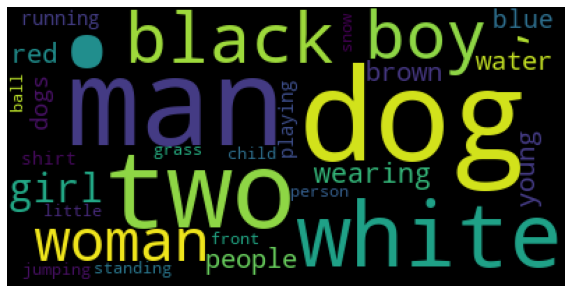

In [15]:
wordcloud = WordCloud(max_words=30).generate_from_frequencies({a: b for a, b in vocabulary.items() if a not in stop_words})
plt.figure(figsize=[10,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [16]:
# Creating a list which contains all the captions
annotations= list(df['caption'])

#adding the <start> & <end> token to all those captions
annotations = ['<start> '+caption+' <end>' for caption in annotations]

# Total captions present in the dataset: 
print("Total captions present in the dataset: "+ str(len(annotations)))
# Total images present in the dataset:
print("Total images present in the dataset: " + str(len(all_img_path_list)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


#### Pre-Processing the captions
We will transform the text captions into integer sequences using the TextVectorization layer. We will perform following steps:
* We will Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to max caption length.
* Create word-to-index and index-to-word mappings to display results.

In [17]:
# Since all captions are of variable length, we will pad all sequences to be the same length as the longest one.
max_sequence_length = max([len(note.split()) for note in annotations])
print("max caption length present in the dataset: " + str(max_sequence_length))

# Keeping the total vocaublary to top 5,000 words for saving memory.
top_n = 5002

# Custom function to standardize the text:
def custom_standardization(input_data):
    txt = tf.strings.lower(input_data)
    txt = tf.strings.regex_replace(txt, r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", '')
    return txt

max caption length present in the dataset: 40


In [18]:
caption_dataset = tf.data.Dataset.from_tensor_slices(annotations) # Creates a `Dataset` whose elements are slices of the given tensors.

In [19]:
# creating the tokenizer
tokenizer = TextVectorization(
    max_tokens = top_n,
    standardize = custom_standardization,
    output_mode='int',
    output_sequence_length = max_sequence_length)

In [20]:
# Learning the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [21]:
print(tokenizer.get_vocabulary())

['', '[UNK]', 'a', '<start>', '<end>', '.', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', ',', 'to', 'wearing', 'at', 'people', 'water', 'red', 'young', 'brown', 'an', 'his', 'blue', 'dogs', 'running', 'through', 'playing', 'while', 'down', 'shirt', 'standing', 'ball', 'little', 'grass', 'child', 'person', 'snow', 'jumping', 'over', 'front', 'three', 'sitting', 'holding', 'field', 'small', 'up', 'by', 'large', 'green', 'group', 'one', 'yellow', 'her', 'walking', 'children', 'men', 'into', 'air', 'beach', 'near', 'mouth', 'jumps', 'another', 'for', 'street', 'runs', 'its', 'from', 'riding', 'stands', 'bike', 'as', 'girls', 'outside', 'other', 'out', 'rock', 'next', 'play', 'off', 'looking', 'orange', 'pink', 'player', 'their', 'pool', 'camera', 'hat', 'jacket', 'boys', 'women', 'around', 'behind', 'some', 'background', 'dirt', 'toy', 'soccer', 'sits', 'dressed', 'has', 'wall', 'mountain', 'walks', 'crowd', 'along', 'p

In [22]:
# Creating tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [23]:
# Creating word-to-index and index-to-word mappings.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Pre-processing the images
We will use InceptionV3 (which is pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer. For that we first need to convert the images into InceptionV3's expected format by:
1. Resizing them into the shape of (299, 299)
2. Normalizing the image within the range of -1 to 1

In [24]:
# Func for reshaping and normalizing
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Loading the pretrained Imagenet weights of Inception net V3

1. We'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. We will use the last convolutional layer because we are using attention in this example.
    * The shape of the output of this layer is 8x8x2048. 
    * We will extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048).
2. We don't perform this initialization during training because it could become a bottleneck and including this as part of training will lead to higher computational time. 
3. To save the memory(RAM) from getting exhausted, we will extract the features of the image using the last layer of pre-trained model.
    * We will forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
    * After all the images are passed through the network, you save the dictionary to disk.

In [25]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
# building the final model using both input & output layer
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [26]:
Batch_size = 16

# extracting features from each image in the dataset
feature_dict = {}
encode_train = sorted(set(all_img_path_list))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(Batch_size)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)  # batch_features shape : (16,8,8,2048)
    batch_features = tf.reshape(
        batch_features,
        (batch_features.shape[0], -1, batch_features.shape[3])
    ) # batch_features shape : (16,8*8,2048)
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  bf.numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 506/506 [00:50<00:00, 10.10it/s]


In [27]:
len(feature_dict)

8091

In [28]:
import gc
gc.collect()

966

## Creating the train & test data 
   * We will Combine both images & captions to create the train & test dataset using tf.data.Dataset API. 
   * We will create the train-test spliit using 80-20 ratio.


In [29]:
img_to_cap_vector = defaultdict(list)

for img, cap in zip(all_img_path_list, cap_vector):
    img_to_cap_vector[img].append(cap)
    
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [30]:
print(f'number of images in training set :{len(img_name_train)}')
print(f'number of captions in training set :{len(cap_train)}')
print(f'number of images in validation set :{len(img_name_val)}')
print(f'number of captions in validation set :{len(cap_val)}')

number of images in training set :32360
number of captions in training set :32360
number of images in validation set :8095
number of captions in validation set :8095


In [31]:
def map_func(img_name, cap):
  img_tensor = feature_dict[img_name.decode('utf-8')]
  return img_tensor, cap

In [32]:
BATCH_SIZE = Batch_size
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE
val_num_steps = len(img_name_val) // BATCH_SIZE

In [33]:
def gen_dataset(img_data, cap_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    # Using map to load the img_data and cap_data parallely.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [34]:
train_dataset=gen_dataset(img_name_train,cap_train)
val_dataset=gen_dataset(img_name_val,cap_val)

In [35]:
dataset = train_dataset.take(1)
for img,cap in dataset:
  print(img.shape)
  print(cap.shape)

(16, 64, 2048)
(16, 40)


## Model Building
1.Building the Encoder, Attention model & Decoder

### Encoder

In [36]:
# Setting the hyperparameters
embedding_dim = 256
units = 512

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [37]:
# This encoder passes those features through a Fully connected layer
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder,self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        # shape after fc == (batch_size, 64, embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [38]:
encoder=Encoder(embedding_dim)

### Attention model

In [39]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        

    def call(self, features, hidden):
        #features shape (encoder output) == (batch_size, 8*8, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        
        # attention_hidden_layer shape == (batch_size, 8*8, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        
        # score shape == (batch_size, 64, 1)
        score = self.V(attention_hidden_layer) # This gives you an unnormalized score for each image feature.
        
        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # context_vector shape after sum == (batch_size, hidden_size)
        return context_vector, attention_weights

In [40]:
attention=Attention_model(units)

### Decoder

In [41]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embedding  = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x,features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        
        # embed shape  == (batch_size, 1, embedding_dim)
        embed = self.embedding(x) 
        
        # Concatenating with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        concatenated =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        
        # Extracting the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,state = self.gru(concatenated)
        
        output = self.d1(output) # shape == (batch_size, max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2])) # shape == (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape == (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [42]:
decoder=Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [43]:
dummy_dataset = train_dataset.take(1)
for img,cap in dummy_dataset:
    print('Image batch shape: ',img.shape)
    print('caption batch shape: ',cap.shape)
    features=encoder(img)
    print('output of encoder (features) shape: ',features.shape)
    hidden = decoder.reset_state(batch_size=cap.shape[0])
    print('hidden state shape: ',hidden.shape)
    dec_input = tf.expand_dims([word_to_index('<start>').numpy()] * cap.shape[0], 1)
    context_vector, attention_weights=attention(features, hidden)
    print('context vector shape: ',context_vector.shape)
    predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
    print('predictions shape: ',predictions.shape)

Image batch shape:  (16, 64, 2048)
caption batch shape:  (16, 40)
output of encoder (features) shape:  (16, 64, 256)
hidden state shape:  (16, 512)
context vector shape:  (16, 256)
predictions shape:  (16, 5002)


## Model training & optimization

In [44]:
#defining the optimizer
optimizer = tf.keras.optimizers.Adam()

#defining loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [45]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [46]:
checkpoint_path = "./checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [47]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

## Training:
* We extract the features stored in the dictionary and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* We then Use teacher forcing to decide the next input to the decoder in which the target word is passed as the next input to the decoder.
* We then calculate the gradients and apply it to the optimizer and backpropagate.

In [48]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [49]:
@tf.function
def val_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [50]:
def val_loss_cal(test_dataset):
    
  total_loss = 0
  for (batch, (img_tensor, target)) in enumerate(test_dataset):
    batch_loss, t_loss = val_step(img_tensor, target)
    
    total_loss += t_loss
    avg_val_loss=total_loss/val_num_steps
  return avg_val_loss

In [51]:
loss_plot = []
val_loss_plot = []
EPOCHS = 20
best_val_loss=100

In [52]:
for epoch in tqdm(range(start_epoch, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / num_steps
    
    # storing the epoch end loss value to plot later
    loss_plot.append(avg_train_loss)    
    val_loss = val_loss_cal(val_dataset)
    val_loss_plot.append(val_loss)

    if batch % 100 == 0:
        print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,val_loss))
        
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
                  
    if val_loss < best_val_loss:
      print('Val loss has been reduced from %.3f to %.3f' % (best_val_loss, val_loss))
      best_val_loss = val_loss
      ckpt_manager.save()

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Time taken for 1 epoch 377.7211346626282 sec

Val loss has been reduced from 100.000 to 0.964


  5%|████                                                                            | 1/20 [06:18<1:59:43, 378.10s/it]

Time taken for 1 epoch 272.9144878387451 sec

Val loss has been reduced from 0.964 to 0.863


 10%|████████                                                                        | 2/20 [10:51<1:34:56, 316.48s/it]

Time taken for 1 epoch 263.0339961051941 sec

Val loss has been reduced from 0.863 to 0.803


 15%|████████████                                                                    | 3/20 [15:14<1:22:48, 292.24s/it]

Time taken for 1 epoch 263.0249879360199 sec

Val loss has been reduced from 0.803 to 0.754


 20%|████████████████                                                                | 4/20 [19:38<1:14:53, 280.85s/it]

Time taken for 1 epoch 272.42495560646057 sec

Val loss has been reduced from 0.754 to 0.712


 25%|████████████████████                                                            | 5/20 [24:11<1:09:29, 277.94s/it]

Time taken for 1 epoch 273.8658378124237 sec

Val loss has been reduced from 0.712 to 0.674


 30%|████████████████████████                                                        | 6/20 [28:45<1:04:33, 276.68s/it]

Time taken for 1 epoch 267.0794460773468 sec

Val loss has been reduced from 0.674 to 0.640


 35%|████████████████████████████▋                                                     | 7/20 [33:12<59:17, 273.68s/it]

Time taken for 1 epoch 262.9359073638916 sec

Val loss has been reduced from 0.640 to 0.609


 40%|████████████████████████████████▊                                                 | 8/20 [37:36<54:04, 270.38s/it]

Time taken for 1 epoch 262.7487623691559 sec

Val loss has been reduced from 0.609 to 0.579


 45%|████████████████████████████████████▉                                             | 9/20 [41:59<49:09, 268.11s/it]

Time taken for 1 epoch 266.15570068359375 sec

Val loss has been reduced from 0.579 to 0.552


 50%|████████████████████████████████████████▌                                        | 10/20 [46:25<44:36, 267.62s/it]

Time taken for 1 epoch 273.48449325561523 sec

Val loss has been reduced from 0.552 to 0.527


 55%|████████████████████████████████████████████▌                                    | 11/20 [50:59<40:25, 269.52s/it]

Time taken for 1 epoch 273.8378129005432 sec

Val loss has been reduced from 0.527 to 0.506


 60%|████████████████████████████████████████████████▌                                | 12/20 [55:33<36:07, 270.95s/it]

Time taken for 1 epoch 273.6566503047943 sec

Val loss has been reduced from 0.506 to 0.487


 65%|███████████████████████████████████████████████████▎                           | 13/20 [1:00:07<31:43, 271.88s/it]

Time taken for 1 epoch 273.80878615379333 sec

Val loss has been reduced from 0.487 to 0.468


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:04:41<27:15, 272.57s/it]

Time taken for 1 epoch 263.760290145874 sec

Val loss has been reduced from 0.468 to 0.454


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:09:06<22:30, 270.03s/it]

Time taken for 1 epoch 263.034996509552 sec

Val loss has been reduced from 0.454 to 0.440


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:13:29<17:52, 268.06s/it]

Time taken for 1 epoch 273.2186059951782 sec

Val loss has been reduced from 0.440 to 0.431


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:18:03<13:29, 269.72s/it]

Time taken for 1 epoch 273.82179832458496 sec

Val loss has been reduced from 0.431 to 0.414


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:22:37<09:02, 271.06s/it]

Time taken for 1 epoch 273.7927734851837 sec

Val loss has been reduced from 0.414 to 0.404


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:27:11<04:31, 271.99s/it]

Time taken for 1 epoch 274.5384488105774 sec

Val loss has been reduced from 0.404 to 0.394


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:31:46<00:00, 275.33s/it]


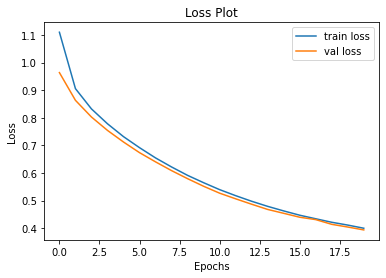

In [62]:
plt.plot(loss_plot)
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(['train loss','val loss'])
plt.show()

## Model Evaluation

### Greedy Search

In [54]:
def evaluate(image):
    attention_plot = np.zeros((max_sequence_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image)[0], 0)     #processing the input image to desired format before extracting features
    
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    
    result = []

    for i in range(max_sequence_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        #map the id to the word from tokenizer and append the value to the result list
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)
        
        if predicted_word == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


### Beam Search

In [78]:
def beam_evaluate(image, beam_index = 3):
    start = [word_to_index('<start>')]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_sequence_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)

    while len(result[0][0]) < max_sequence_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [index_to_word(i) for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(tf.compat.as_text(i.numpy()))
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [56]:
def plot_attention(result, attention_plot,image):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [57]:
def filt_text(text):
    filt=['<start>','[unk]','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 100.0
Real Caption: a man sits on a dock with a bottle of water .
Prediction Caption: a man sits on a dock with a bottle of water .


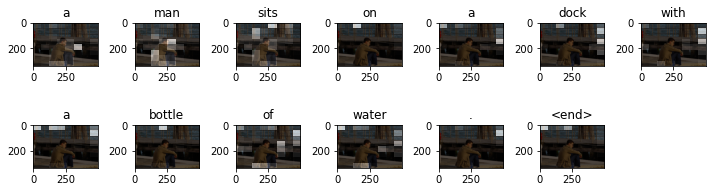

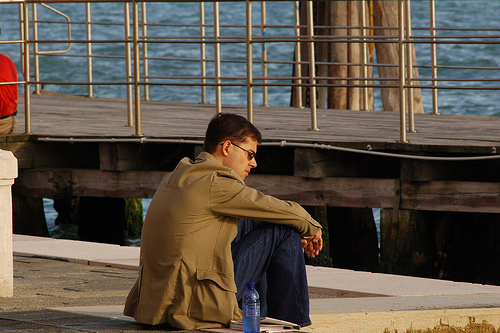

In [87]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attention(result, attention_plot, image)


Image.open(image)

In [88]:
captions=beam_evaluate(image)
print(captions)

the man near jetty .


#### Text to speech using google API

In [82]:
from gtts import gTTS

In [89]:
language = 'en'
txt2spch = gTTS(text=captions, lang=language, slow=False)
txt2spch.save("predicted_caption.mp3")

In [91]:
# Playing the converted file
os.system("predicted_caption.mp3")

0